#### 0. Import required libraries

In [17]:
import math
import numpy
from matplotlib import pyplot
import sympy  # Used for solving symbolic expressions

%matplotlib inline

#### 1. Create the NACA airfoil 

First step is to define the geometries of the NACA airfoil. The following cell defines the function to create the cambert line of a four digit NACA airfoil using two parabolas. Furthar, the thickness is used to define the upper and lower surfaces of teh airfoil. Points are alos plotted from a data base of the airfoils to verify if the plotted airfoil is the correct one.

In [18]:
# Function to create a NACA 4 digit airfoil.

def naca4(NACA="4412", n = 500):
    """
    Plots a 4 digit NACA airfoil given a 4 digit input string
    inputs: the four-digit NACA airfoil number
            : n = number of the chordwise points on the airfoil.
    """
    m = float(NACA[0])/100
    p = float(NACA[1])/10
    t = float(NACA[2:])/100
    
    if m == 0:
        print(f"NACA {NACA} is a symmetric airfoil, with a thickness of {t:1.1f}")
    else:
        print(f"NACA {NACA} has a max camber of {m:1.3f}, at {p:1.2f}, with a thickness of {t:1.1f}")

    x = numpy.linspace(0, 1, n)

    def camberline(x, m, p):
        y_c = numpy.zeros(x.shape)      # This function initiates the array/matrix to zero
        y_c[x<p] = m * x[x<p] / p**2 * (2*p - x[x<p])
        y_c[x>=p] = m * (1 - x[x>=p]) / (1 - p)**2 *(1 + x[x>=p] - 2*p)
        return y_c
    y_c = camberline(x, m, p)

    def theta_func(x, m, p):
        if m > 0:
            dzdx = numpy.zeros(x.shape)
            dzdx[x<p] = 2*m / p**2 * (p - x[x<p])
            dzdx[x>=p] = 2*m / (1-p)**2 * (p - x[x>=p])
            theta = numpy.arctan(dzdx)
        else:
            theta = 0
        return theta
    theta = theta_func(x, m, p)
    theta_input = theta

    # We need the thickness so we write the coefficients first
    a0 = 0.2969
    a1 = -0.126
    a2 = -0.3516
    a3 = 0.2843
    a4 = -0.1036
    y_t = 5 * t * (a0*x**0.5 + a1*x + a2 * x**2 + a3*x**3 + a4*x**4)
   
    x_u = x - y_t*numpy.sin(theta)
    x_l = numpy.flip(x + y_t*numpy.sin(theta))

    y_u = y_c + y_t*numpy.cos(theta)
    y_l = numpy.flip(y_c - y_t*numpy.cos(theta))
 
    # Export to a single file to plot and discretize
    surf_x = numpy.concatenate((x_u, x_l))
    surf_y = numpy.concatenate((y_u, y_l))

    fig, ax = pyplot.subplots(1, 2, figsize = (16, 4))
    ax[0].plot(x, y_c, '-b')
    ax[0].plot(x_u, y_u, '-r')
    ax[0].plot(x_l, y_l, '-g')
    ax[0].set_title('NACA ' + str(int(m * 100)) + str(int(p * 10)) + str(int(t * 100)) + ' plot for Thin Airfoil Theory')
    ax[0].set_ylim([-0.2, 0.2])
    ax[1].plot(surf_x, surf_y)
    ax[1].set_title('NACA ' + str(int(m * 100)) + str(int(p * 10)) + str(int(t * 100)) + ' plot for Vortex Panel Method')
    ax[1].set_ylim([-0.2, 0.2])

    return surf_x, surf_y, m, p, theta_input, x_u


##### 1.1 Plot the airfoil
Using the functions above, plot the camberline and the airfoil upper and lower surfaces.

NACA 4412 has a max camber of 0.040, at 0.40, with a thickness of 0.1


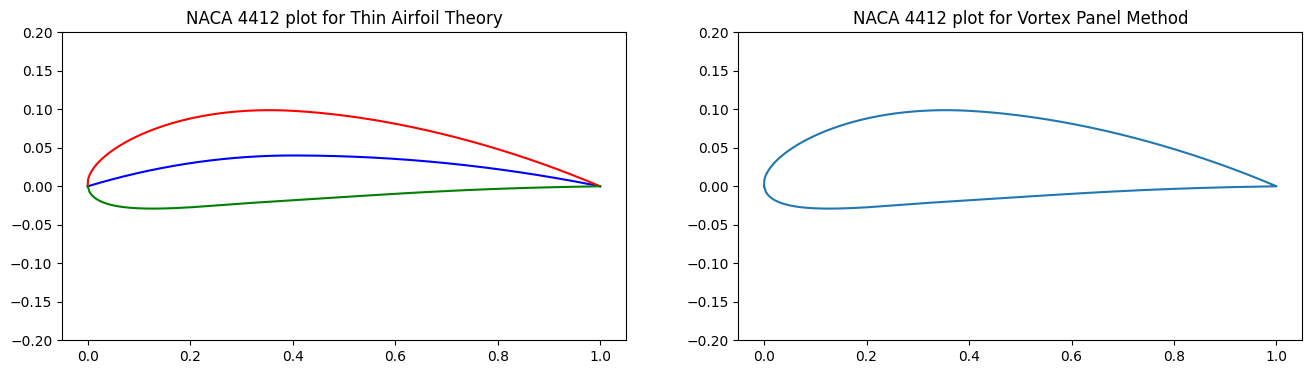

In [19]:
naca_x, naca_y, m, p, theta_input, x_u = naca4("4412");

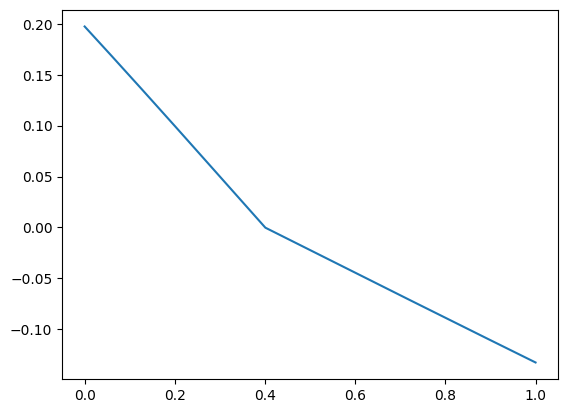

In [20]:
bsdk = numpy.linspace(0, 1, 500)
pyplot.plot(bsdk, theta_input)

## Vortex Panel Method

#### 2. Defining the panels
##### 2.1 How are streamlines formed?

To satisfy the condition that the surface of the airfoil should be a strealine is satisfied by equatiing the normal component of velocity to zero at the control points throughout the geometry.

$$
\phi\left(x_i, y_i\right)=-\sum_{j=1}^n \frac{\gamma_j}{2 \pi} \int_j \theta_{i j} d s_j
$$

In [21]:
def centre_points(naca_x, naca_y):
    n = numpy.shape(naca_x)[0] - 1
    centres = numpy.zeros((n, 2))
    for i in range(0, n):
        centres[i, 0] = 0.5 * (naca_x[i] + naca_x[i + 1])
        centres[i, 1] = 0.5 * (naca_y[i] + naca_y[i + 1])
    pyplot.scatter(naca_x, naca_y)
    pyplot.plot(naca_x, naca_y)
    return n, centres
#hey

(999,
 array([[ 0.00023866,  0.00403583],
        [ 0.0011772 ,  0.00981589],
        [ 0.00265437,  0.01292607],
        ...,
        [ 0.00736567, -0.01093511],
        [ 0.00483482, -0.00861851],
        [ 0.00176535, -0.00363603]]))

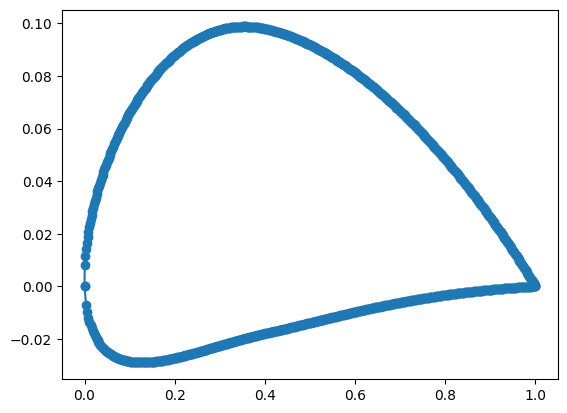

In [22]:
centre_points(naca_x, naca_y)

In [23]:
def panels(naca_x, naca_y, N=30):
    """
    Cosine method to discretize the geometry into panels
    
    Inputs__>
    naca_x: x coordinate to the naca4 airfoil
    naca_y: corresponding y coordinate of the naca4 airfoil
    N: number of panels to be discretized to.

    Returns__>
    panels: numpy array of all the panels created using the function

    Methodology adopted from "https://github.com/barbagroup/AeroPython"    

    """
    
    # Using maximum and minimum x coordinates to create a circle around the airfoil

    R = (naca_x.max() - naca_x.min())/2             # Radius of the circle
    centre_x = (naca_x.max() + naca_x.min())/2      # Coordinate of the radius of the circle in x

    panel_angle = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)      # Create an array of angles
    circle_x =  centre_x + R * numpy.cos(panel_angle)             # x_coordiante of the circle

    x_ends = numpy.copy(circle_x)
    y_ends = numpy.empty_like(x_ends)       # Create and empty array to fill using the x-coordinates

    # Since the airfoil is a closed surface, an extra point is to be appended to compute the centres at all points.
    # naca_x, naca_y = numpy.append(naca_x, naca_x[0]), numpy.append(naca_y, naca_y[0])


    

## Thin Airfoil Theory

In [24]:

def thin_airfoil(m, p, theta_input):

    """
    This function calculates for cl, angle of zero lift and pitching moment using thin airfoil theory
    
    """
    c = 1
    n = 1
    U_inf = 10      #[m/s]
    # Sympy Operations
    x = sympy.symbols('x')
    theta = sympy.symbols('theta')
    alpha =  0.0698132     # in radianssympy.symbols('alpha')

    # Converting x to theta and evaluating p_break in radians
    x = (c / 2) * (1 - sympy.cos(theta))
    p_break = sympy.acos(1 - (2*p/c))
    
    # NON SYMMETRIC AIRFOIL
    if m > 0:
        # Camber_functions as functions of theta
        camber_function_1 = (2 * m / p**2) * (p - x)               # for x < p
        camber_function_2 = (2 * m/ (1 - p)**2) * (p - x)          # for x >= p
    
        A_0 = alpha - (1 / numpy.pi) *  (              (sympy.integrate(camber_function_1, (theta, 0, p_break)))               +              (sympy.integrate(camber_function_2, (theta, p_break, numpy.pi)))  )
        A_1 = (2 / numpy.pi) *          (   (sympy.integrate(camber_function_1 * sympy.cos(n * theta), (theta, 0, p_break)))   +   (sympy.integrate(camber_function_2 * sympy.cos(n * theta), (theta, p_break, numpy.pi))))
        c_l = 2 * numpy.pi * (A_0 + (A_1 / 2))
        c_l = sympy.simplify(c_l)

        alpha_lift_0 = (-1/numpy.pi) *     (   (sympy.integrate(camber_function_1 * (sympy.cos(theta) - 1), (theta, 0, p_break))) +   (sympy.integrate(camber_function_2 * (sympy.cos(theta) - 1), (theta, p_break, numpy.pi)))   ) * (180/numpy.pi)


        gamma_expr = 2 * U_inf * (    A_0 * ((1 + sympy.cos(theta))/ sympy.sin(theta))   +   A_1 * sympy.sin(n * theta))
        gamma_f = sympy.lambdify([theta], gamma_expr)

        gamma = numpy.zeros(len(theta_input))

        for i in range(len(theta_input)):
            gamma[i] = gamma_f(theta_input[i])
        
        # display(gamma)
        
    # SYMMETRIC AIRFOIL
    else:
        c_l = 2 * numpy.pi * alpha
        alpha_lift_0 = 0
        gamma = 2 * alpha * ((1 + numpy.cos(theta_input))/ numpy.sin(theta_input))

    print(gamma)


    return c_l, alpha_lift_0, gamma

a, b, c = thin_airfoil(m, p, theta_input)

#pyplot.scatter(x_u, c)

[ 1.29252480e+01  1.29828317e+01  1.30410335e+01  1.30998628e+01
  1.31593293e+01  1.32194429e+01  1.32802135e+01  1.33416516e+01
  1.34037675e+01  1.34665720e+01  1.35300761e+01  1.35942908e+01
  1.36592276e+01  1.37248981e+01  1.37913143e+01  1.38584882e+01
  1.39264324e+01  1.39951594e+01  1.40646824e+01  1.41350144e+01
  1.42061691e+01  1.42781604e+01  1.43510024e+01  1.44247096e+01
  1.44992968e+01  1.45747792e+01  1.46511723e+01  1.47284919e+01
  1.48067543e+01  1.48859762e+01  1.49661744e+01  1.50473665e+01
  1.51295703e+01  1.52128040e+01  1.52970863e+01  1.53824363e+01
  1.54688738e+01  1.55564187e+01  1.56450917e+01  1.57349140e+01
  1.58259071e+01  1.59180932e+01  1.60114950e+01  1.61061360e+01
  1.62020401e+01  1.62992317e+01  1.63977361e+01  1.64975791e+01
  1.65987873e+01  1.67013878e+01  1.68054087e+01  1.69108787e+01
  1.70178272e+01  1.71262846e+01  1.72362820e+01  1.73478514e+01
  1.74610256e+01  1.75758384e+01  1.76923247e+01  1.78105201e+01
  1.79304615e+01  1.80521